In [7]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
import numpy as np
import tensorflow as tf
from keras.utils import plot_model
from SpectralLayer import Spectral
from tensorflow.keras.layers import Dense
from Jlayers import*
import matplotlib

# Dataset

In [8]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

flat_train = np.reshape(x_train, [x_train.shape[0], 28 * 28])
flat_test = np.reshape(x_test, [x_test.shape[0], 28 * 28])

# Model spectral

In [9]:
spectral_config={
    'is_base_trainable' : False,
    'is_diag_start_trainable' : False,
    'is_diag_end_trainable' : True,
    'use_bias' : False
}

In [5]:

accuracy=list()
N2=[20,80,100,500,800,1000,1500,2000]

epochs = 20
for i in range(len(N2)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28 * 28), dtype='float32'))
    model.add(Spectral(N2[i],  **spectral_config))
    model.add(Spectral(10,  **spectral_config,activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(flat_train, y_train, batch_size=200, epochs=epochs,verbose=0)
    accuracy.append(model.evaluate(flat_test,y_test,batch_size=32,verbose="auto"))



313/313 [==============================] - 1s 4ms/step - loss: 0.3162 - accuracy: 0.9124


In [6]:
score=list()
for i in range(len(N2)):
    score.append(accuracy[i][1])


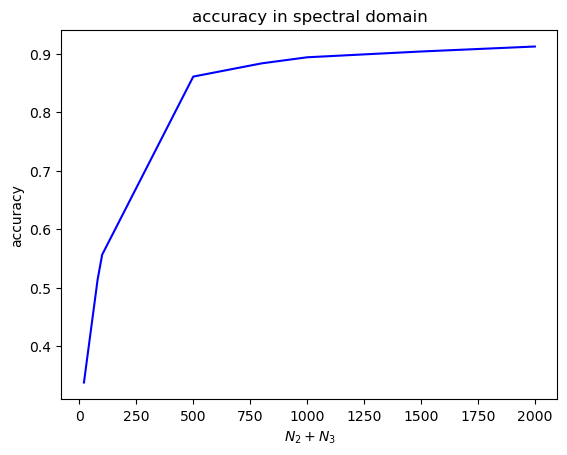

In [7]:
plt.plot(N2,score, "b")
plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("accuracy")
plt.title("accuracy in spectral domain")
plt.show()

# Direct space

In [27]:
N21=[20,80,100,500,800,1000,1500,2000]
accuracy1=list()
for i in range(len(N21)):
    model1 = tf.keras.Sequential()
    model1.add(tf.keras.layers.Input(shape=(28 * 28), dtype='float32'))
    model1.add(Dense(N21[i],use_bias=False))
    model1.add(Dense(10, use_bias=False, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model1.fit(flat_train, y_train, batch_size=200, epochs=epochs,verbose=0,validation_data=(flat_test, y_test))
    accuracy1.append(model1.evaluate(flat_test,y_test,batch_size=32,verbose="auto"))

313/313 [==============================] - 3s 9ms/step - loss: 0.3367 - accuracy: 0.9129


In [28]:
score1=list()
for i in range(len(N21)):
    score1.append(accuracy1[i][1])


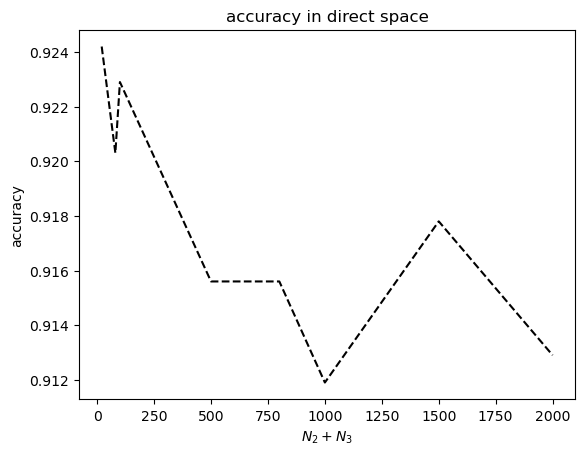

In [29]:
plt.plot(N21,score1, "k--"  )
plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("accuracy")
plt.title("accuracy in direct space")
plt.show()

## Direct space Collapse

In [19]:
N=[3,9,11,51,81,101,151,201]
accuracy2=list()
epochs=20
for i in range(len(N21)):
    model2 = tf.keras.Sequential()
    model2.add(tf.keras.layers.Input(shape=(28 * 28), dtype='float32'))
    model2.add(Dense(N[i],use_bias=False))
    model2.add(Dense(10, use_bias=False, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model2.fit(flat_train, y_train, batch_size=200, epochs=epochs,verbose=0,validation_data=(flat_test, y_test))
    accuracy2.append(model2.evaluate(flat_test,y_test,batch_size=32,verbose="auto"))

313/313 [==============================] - 3s 7ms/step - loss: 0.3043 - accuracy: 0.9197


In [20]:
score2=list()
for i in range(len(N21)):
    score2.append(accuracy2[i][1])


In [1]:
plt.plot(N21,score2, "b--"  )
plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("accuracy")
plt.title("accuracy in direct space collapse")
plt.show()

NameError: name 'plt' is not defined

# Direct space constraint

In [23]:
N21=[20,80,100,500,800,1000,1500,2000]
accuracy3=list()
epochs=20
for i in range(len(N21)):
    model3 = tf.keras.Sequential()
    model3.add(tf.keras.layers.Input(shape=(28 * 28), dtype='float32'))
    model3.add(SimpleLayer(N21[i],number_params_train=N21[i],activation=None))
    model3.add(SimpleLayer(10,number_params_train=10,activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.003)
    model3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model3.fit(flat_train, y_train, batch_size=200, epochs=epochs,verbose=0,validation_data=(flat_test, y_test))
    accuracy3.append(model3.evaluate(flat_test,y_test,batch_size=32,verbose="auto"))

313/313 [==============================] - 13s 40ms/step - loss: 0.4435 - accuracy: 0.8747


In [24]:
score3=list()
for i in range(len(N21)):
    score3.append(accuracy3[i][1])


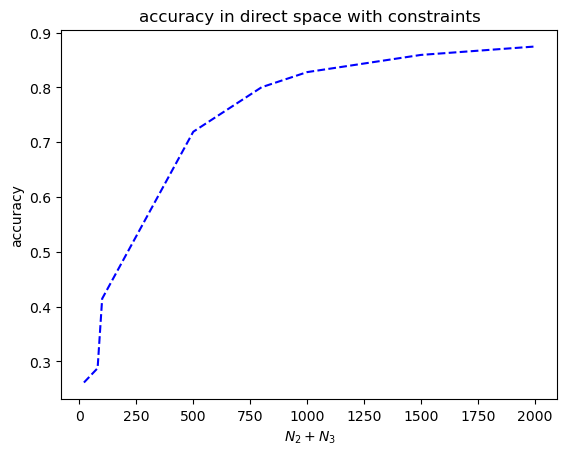

In [25]:
plt.plot(N21,score3, "b--"  )
plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("accuracy")
plt.title("accuracy in direct space with constraints")
plt.show()

# Spectral domain against direct space

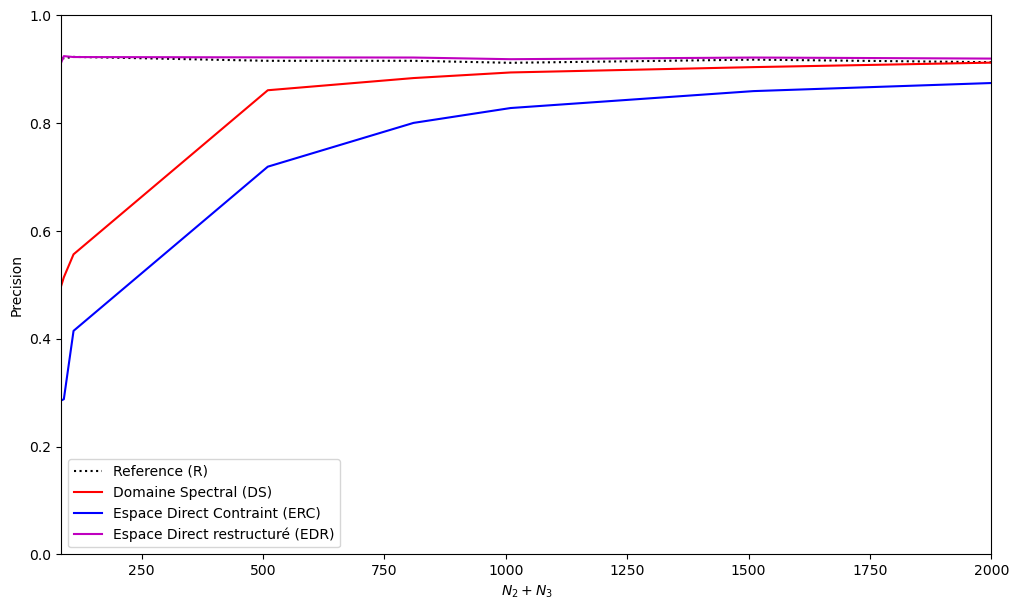

In [31]:
fig=plt.figure(num=1,figsize=(12,7)) 
N=[30,90,110,510,810,1010,1510,2010]
plt.plot(N,score1, "k:")
plt.plot(N,score, "r")
plt.plot(N,score3, "b-")
plt.plot(N,score2, "m-")

plt.axis([85, 2000, 0, 1])

plt.xlabel("$N_{2}+N_{3}$")
plt.ylabel("Precision")


plt.legend(['Reference (R)', 'Domaine Spectral (DS) ','Espace Direct Contraint (ERC)','Espace Direct restructuré (EDR)'])

plt.show()